# Setting

In [2]:
import bt
import FinanceDataReader as fdr
import pandas as pd

from pf_utils import convert_rate_to_price
from pf_utils import Backtest, get_date_range, metrics

In [3]:
path_data = 'data'

In [4]:
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

## testing

### class

### test

In [183]:
bts.portfolios

{'KOSPI': <bt.backtest.Backtest at 0x76131c8a5160>,
 'TDF COMB': <bt.backtest.Backtest at 0x761317e05e20>,
 'TDF COMB w/fee': <bt.backtest.Backtest at 0x761317e04530>,
 'TDF COMB DCA': <bt.backtest.Backtest at 0x761317e07500>,
 'TDF COMB DCA w/fee': <bt.backtest.Backtest at 0x761317e07ef0>,
 'TDF COMB DCA2': <bt.backtest.Backtest at 0x761317e07b90>,
 'ETF COMB1': <bt.backtest.Backtest at 0x761317e074d0>,
 'ETF COMB2': <bt.backtest.Backtest at 0x761317e06330>}

In [122]:
import bt
t0 = bts.portfolios['KOSPI']
t1 = bts.portfolios['TDF COMB']
t2 = bts.portfolios['ETF COMB1']
t3 = bts.portfolios['ETF COMB2']
t4 = bts.portfolios['TDF COMB DCA']
res = bt.run(t0,t1,t2,t3,t4)

# Data

## TDF
- https://www.kiwoomam.com/fund/KI0202020000M?parentfundcode=8325&fundcode=8335
- https://investments.miraeasset.com/fund/view.do?fundGb=2&fundCd=537380&childFundGb=2&childFundCd=53738P
- https://www.hanwhawm.com/main/finance/fundInfo/FI141_2.cmd?p=500&item_cd=5102896

In [5]:
file = '금융자산운용 - export.csv'
df_info = pd.read_csv(f'{path_data}/{file}')

In [6]:
tdf_names = df_info.set_index('ticker')['name'].to_dict()
commissions = df_info.set_index('ticker')['commission'].to_dict()
{tdf_names[k]:v for k,v in commissions.items()}

{'미래에셋전략배분TDF2035혼합자산자투자신탁종류C-P2e': 0.6,
 '키움키워드림TDF2030증권투자신탁 1[혼합-재간접형]C-P2e(퇴직연금)': 0.48,
 '미래에셋평생소득TIF혼합자산자투자신탁종류C-P2e': 0.54,
 '미래에셋전략배분TDF2045혼합자산자투자신탁 종류C-P2e': 0.74,
 '키움키워드림TDF2045증권투자신탁 1[혼합-재간접형]C-P2e(퇴직연금)': 0.68,
 'KODEX 미국S&P500TR assumed from S&P500 rate of return': 0.0}

In [7]:
df_info = df_info.iloc[:-1]
df_tdfs = None

for _, data in df_info.iterrows():
    df = convert_rate_to_price(data, path=path_data)
    
    if df_tdfs is None:
        df_tdfs = df.to_frame()
    else:
        df_tdfs = df_tdfs.join(df, how='outer')

error: -0.07 %
error: -0.00 %
error: 0.16 %
error: -0.13 %
error: 0.00 %


In [8]:
get_date_range(df_tdfs)

,start date,end date
K55301BU5479,2017-08-14,2024-06-16
K55301BU6139,2017-09-20,2024-06-16
K55301BU5453,2017-09-29,2024-06-16
K55206C96311,2018-07-13,2024-06-17
K55206C95800,2018-07-26,2024-06-13


<Axes: xlabel='date'>

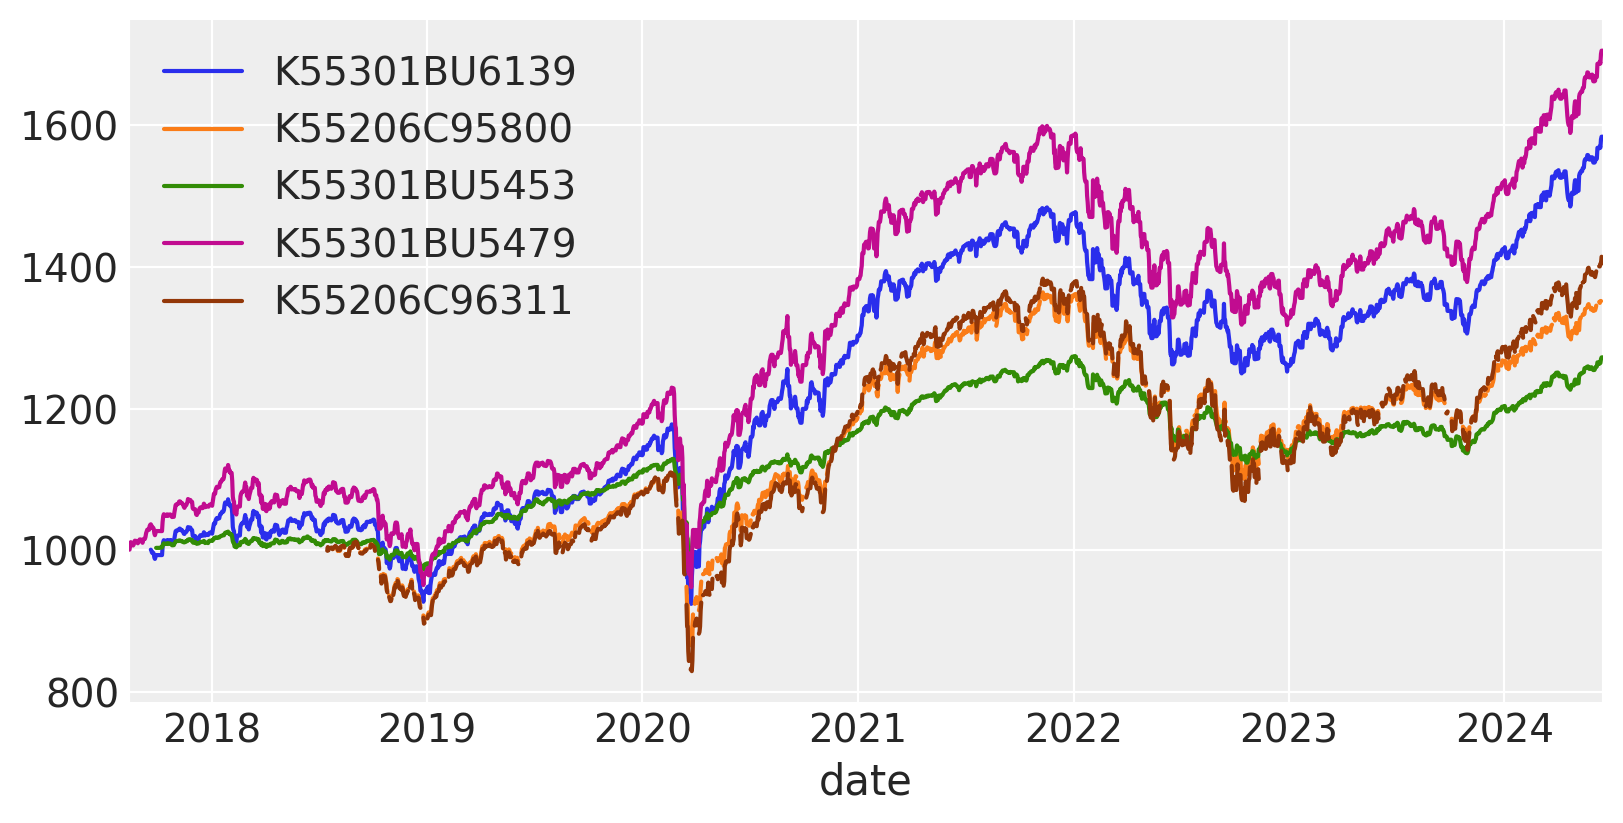

In [9]:
df_tdfs.plot(figsize=(8,4))

## ETF

In [10]:
file = 'etfs_selected_240611.csv'
df_etfs = pd.read_csv(f'{path_data}/{file}', parse_dates=[0], index_col=0)
df_etfs.head()

,273130,453850,284430,069500,379800,411060,305080,304660,148070,261220
Date,,,,,,,,,,
2002-10-14,NaN,NaN,NaN,5184,NaN,NaN,NaN,NaN,NaN,NaN
2002-10-15,NaN,NaN,NaN,5312,NaN,NaN,NaN,NaN,NaN,NaN
2002-10-16,NaN,NaN,NaN,5335,NaN,NaN,NaN,NaN,NaN,NaN
2002-10-17,NaN,NaN,NaN,5410,NaN,NaN,NaN,NaN,NaN,NaN
2002-10-18,NaN,NaN,NaN,5642,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df_sym = fdr.StockListing('ETF/KR') # 한국 ETF 전종목

symbols = df_etfs.columns
etf_names = df_sym.loc[df_sym.Symbol.isin(symbols)].set_index('Symbol')['Name'].to_dict()
etf_names

{'069500': 'KODEX 200',
 '273130': 'KODEX 종합채권(AA-이상)액티브',
 '379800': 'KODEX 미국S&P500TR',
 '453850': 'ACE 미국30년국채액티브(H)',
 '148070': 'KOSEF 국고채10년',
 '304660': 'KODEX 미국30년국채울트라선물(H)',
 '411060': 'ACE KRX금현물',
 '305080': 'TIGER 미국채10년선물',
 '284430': 'KODEX 200미국채혼합',
 '261220': 'KODEX WTI원유선물(H)'}

In [12]:
get_date_range(df_etfs)

,start date,end date
069500,2002-10-14,2024-06-11
148070,2011-10-20,2024-06-11
261220,2016-12-27,2024-06-11
273130,2017-06-29,2024-06-11
284430,2017-11-30,2024-06-11
305080,2018-08-30,2024-06-11
304660,2018-09-12,2024-06-11
379800,2021-04-09,2024-06-11
411060,2021-12-15,2024-06-11
453850,2023-03-14,2024-06-11


In [13]:
equity_names = etf_names.copy()
equity_names.update(tdf_names)

# Backtest

## Setting

In [13]:
{x: equity_names[x] for x in df_tdfs.columns}

{'K55301BU6139': '미래에셋전략배분TDF2035혼합자산자투자신탁종류C-P2e',
 'K55206C95800': '키움키워드림TDF2030증권투자신탁 1[혼합-재간접형]C-P2e(퇴직연금)',
 'K55301BU5453': '미래에셋평생소득TIF혼합자산자투자신탁종류C-P2e',
 'K55301BU5479': '미래에셋전략배분TDF2045혼합자산자투자신탁 종류C-P2e',
 'K55206C96311': '키움키워드림TDF2045증권투자신탁 1[혼합-재간접형]C-P2e(퇴직연금)'}

In [14]:
cols = ['K55301BU6139', 'K55206C95800']
df1 = df_tdfs[cols]
[equity_names[x] for x in df1.columns]

['미래에셋전략배분TDF2035혼합자산자투자신탁종류C-P2e',
 '키움키워드림TDF2030증권투자신탁 1[혼합-재간접형]C-P2e(퇴직연금)']

In [15]:
{x:equity_names[x] for x in df_etfs.columns}

{'273130': 'KODEX 종합채권(AA-이상)액티브',
 '453850': 'ACE 미국30년국채액티브(H)',
 '284430': 'KODEX 200미국채혼합',
 '069500': 'KODEX 200',
 '379800': 'KODEX 미국S&P500TR',
 '411060': 'ACE KRX금현물',
 '305080': 'TIGER 미국채10년선물',
 '304660': 'KODEX 미국30년국채울트라선물(H)',
 '148070': 'KOSEF 국고채10년',
 '261220': 'KODEX WTI원유선물(H)'}

In [16]:
#cols = ['069500', '148070', '305080', '379800']
cols = ['069500', '273130', '148070', '379800']
df2 = df_etfs[cols]
{x:equity_names[x] for x in df2.columns}

{'069500': 'KODEX 200',
 '273130': 'KODEX 종합채권(AA-이상)액티브',
 '148070': 'KOSEF 국고채10년',
 '379800': 'KODEX 미국S&P500TR'}

In [17]:
df = df1.join(df2, how='outer')

bts = Backtest(df, metrics=metrics, initial_capital=10000000,
               equity_names=equity_names, commissions=None)

backtest period reset: 2021-04-09 ~ 2024-06-11
rate of nan filled forward::
  K55301BU6139: 0.001
  K55206C95800: 0.478
  069500: 0.485
  273130: 0.485
  148070: 0.485
  379800: 0.485


Baseline

In [18]:
name = 'KOSPI'
ticker = '069500'
bts.buy_n_hold(ticker, name=name)

## TDF

In [19]:
tickers = ['K55301BU6139', 'K55206C95800']
weights = [0.5, 0.5]
weights = dict(zip(tickers, weights))

In [20]:
name = 'TDF COMB'
bts.build(weights, name, period='Y')

In [21]:
name = 'TDF COMB w/fee'
bts.build(weights, name, period='Y', commissions=commissions)

In [22]:
name = 'TDF COMB DCA'
bts.build(weights, name, period='M', 
          initial_capital=0, capital_flow=1000000)

In [23]:
name = 'TDF COMB DCA w/fee'
bts.build(weights, name, period='M', 
          initial_capital=0, capital_flow=1000000, commissions=commissions)

In [24]:
name = 'TDF COMB DCA2'
bts.build(weights, name, period='Q', 
          #initial_capital=0, 
          capital_flow=5000000, commissions=commissions)

## ETF

In [25]:
etfs = ['069500', '273130', '148070', '379800']
[equity_names[x] for x in etfs]

['KODEX 200', 'KODEX 종합채권(AA-이상)액티브', 'KOSEF 국고채10년', 'KODEX 미국S&P500TR']

In [26]:
name = 'ETF COMB1'
weights = [0.2, 0.2, 0.3, 0.3]
weights = dict(zip(etfs, weights))
bts.build(weights, name, period='Y')

In [27]:
name = 'ETF COMB2'
weights = [0.3, 0.2, 0.3, 0.2]
weights = dict(zip(etfs, weights))
bts.build(weights, name, period='Y')

## Compare

,KOSPI,TDF COMB,TDF COMB w/fee,TDF COMB DCA,TDF COMB DCA w/fee,TDF COMB DCA2,ETF COMB1,ETF COMB2
start,2021-04-08 00:00:00,2021-04-08 00:00:00,2021-04-08 00:00:00,2021-04-08 00:00:00,2021-04-08 00:00:00,2021-04-08 00:00:00,2021-04-08 00:00:00,2021-04-08 00:00:00
end,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00
total_return,-0.07205,0.095495,0.089502,0.080366,0.077757,0.075071,0.160406,0.091834
cagr,-0.02327,0.029135,0.027359,0.024638,0.023858,0.023054,0.047958,0.02805
max_drawdown,-0.342102,-0.174055,-0.174059,-0.166899,-0.167251,-0.158577,-0.141659,-0.16493
avg_drawdown,-0.085707,-0.016229,-0.016504,-0.016196,-0.014564,-0.011319,-0.01141,-0.013601
avg_drawdown_days,229.0,56.210526,56.578947,63.235294,56.842105,48.363636,34.129032,43.48
daily_vol,0.136883,0.052665,0.052722,0.050338,0.050339,0.046337,0.06132,0.063515
daily_sharpe,-0.050308,0.402564,0.379586,0.358775,0.348333,0.362538,0.557741,0.332261
daily_sortino,-0.079776,0.611235,0.576085,0.545526,0.529736,0.556782,0.867468,0.51778


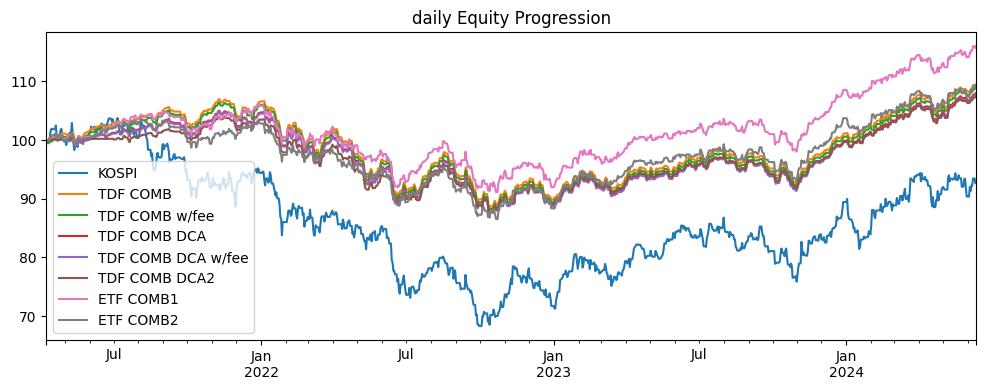

In [28]:
bts.run(figsize=(12,4))

,KOSPI,TDF COMB,TDF COMB w/fee,TDF COMB DCA,TDF COMB DCA w/fee,TDF COMB DCA2
start,2021-04-08 00:00:00,2021-04-08 00:00:00,2021-04-08 00:00:00,2021-04-08 00:00:00,2021-04-08 00:00:00,2021-04-08 00:00:00
end,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00
total_return,-0.07205,0.095495,0.089502,0.080366,0.077757,0.075071
cagr,-0.02327,0.029135,0.027359,0.024638,0.023858,0.023054
max_drawdown,-0.342102,-0.174055,-0.174059,-0.166899,-0.167251,-0.158577
avg_drawdown,-0.085707,-0.016229,-0.016504,-0.016196,-0.014564,-0.011319
avg_drawdown_days,229.0,56.210526,56.578947,63.235294,56.842105,48.363636
daily_vol,0.136883,0.052665,0.052722,0.050338,0.050339,0.046337
daily_sharpe,-0.050308,0.402564,0.379586,0.358775,0.348333,0.362538
daily_sortino,-0.079776,0.611235,0.576085,0.545526,0.529736,0.556782


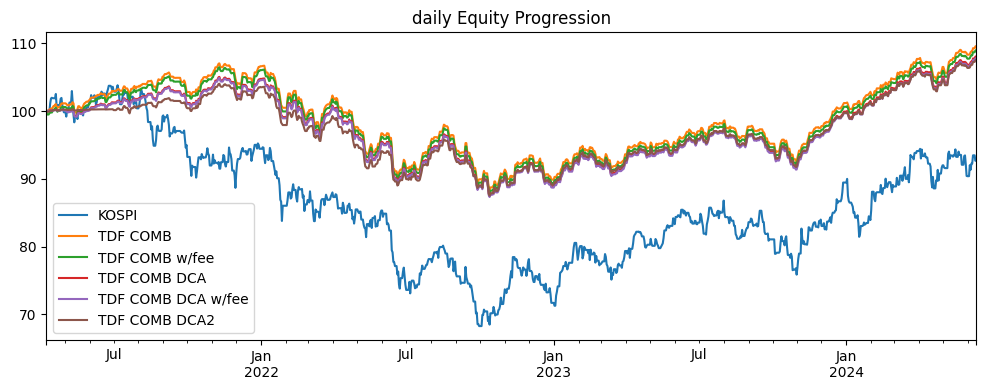

In [29]:
bts.run(range(6), figsize=(12,4))

In [30]:
{i:x for i,x in enumerate(bts.portfolios.keys())}

{0: 'KOSPI',
 1: 'TDF COMB',
 2: 'TDF COMB w/fee',
 3: 'TDF COMB DCA',
 4: 'TDF COMB DCA w/fee',
 5: 'TDF COMB DCA2',
 6: 'ETF COMB1',
 7: 'ETF COMB2'}

,KOSPI,TDF COMB,TDF COMB DCA,TDF COMB DCA2,ETF COMB1,ETF COMB2
start,2021-04-08 00:00:00,2021-04-08 00:00:00,2021-04-08 00:00:00,2021-04-08 00:00:00,2021-04-08 00:00:00,2021-04-08 00:00:00
end,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00
total_return,-0.07205,0.095495,0.080366,0.075071,0.160406,0.091834
cagr,-0.02327,0.029135,0.024638,0.023054,0.047958,0.02805
max_drawdown,-0.342102,-0.174055,-0.166899,-0.158577,-0.141659,-0.16493
avg_drawdown,-0.085707,-0.016229,-0.016196,-0.011319,-0.01141,-0.013601
avg_drawdown_days,229.0,56.210526,63.235294,48.363636,34.129032,43.48
daily_vol,0.136883,0.052665,0.050338,0.046337,0.06132,0.063515
daily_sharpe,-0.050308,0.402564,0.358775,0.362538,0.557741,0.332261
daily_sortino,-0.079776,0.611235,0.545526,0.556782,0.867468,0.51778


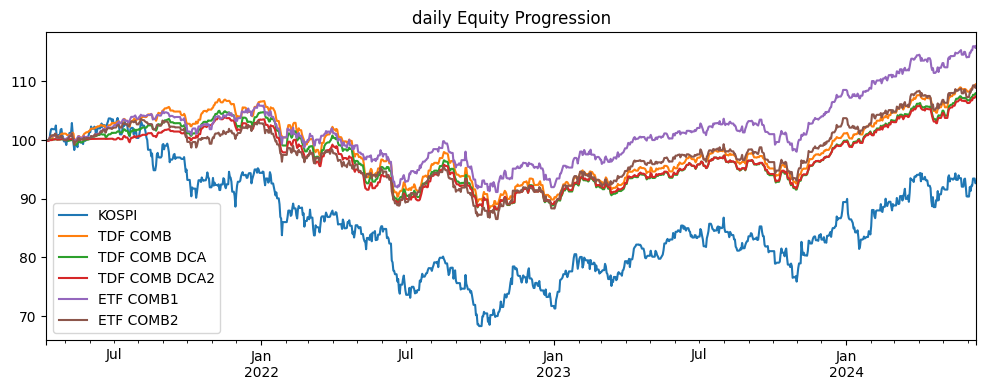

In [31]:
bts.run([0,1,3,5,6,7], figsize=(12,4))

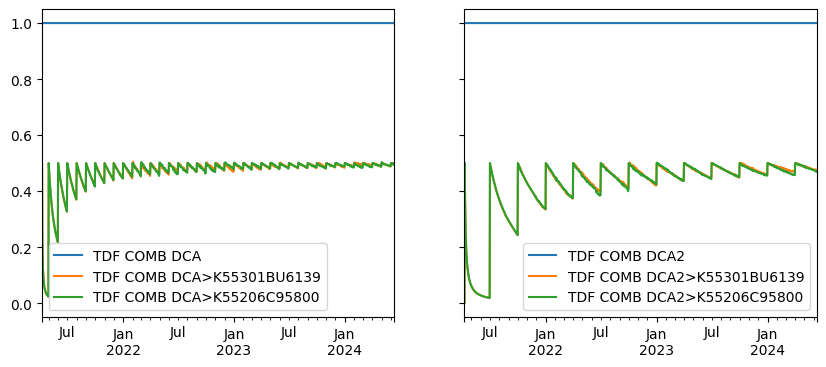

In [41]:
bts.plot_weights([2,3], figsize=(10,4))

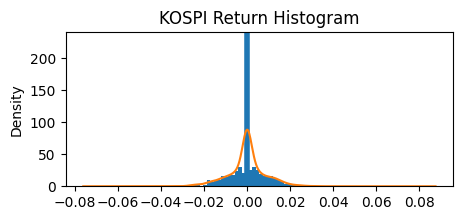

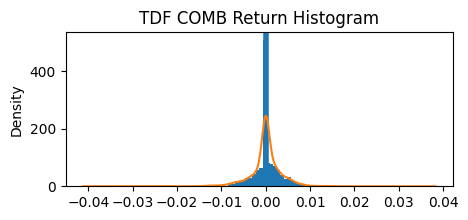

In [49]:
bts.plot_histogram([0,1], bins=50, figsize=(5,2))

# Scaled

## Data

In [45]:
etfs = ['069500', '273130', '148070', '379800']
{x: etf_names[x] for x in etfs}

{'069500': 'KODEX 200',
 '273130': 'KODEX 종합채권(AA-이상)액티브',
 '148070': 'KOSEF 국고채10년',
 '379800': 'KODEX 미국S&P500TR'}

In [46]:
get_date_range(df_etfs[etfs])

,start date,end date
069500,2002-10-14,2024-06-11
148070,2011-10-20,2024-06-11
273130,2017-06-29,2024-06-11
379800,2021-04-09,2024-06-11


In [47]:
start_date = '2017-06-29'

In [48]:
df_snp = fdr.DataReader('S&P500')
df_snp = df_snp['Adj Close']
df_rate = df_snp/df_snp[0]-1
df_rate

Date
1980-01-02     0.000000
1980-01-03    -0.005106
1980-01-04     0.007186
1980-01-07     0.009928
1980-01-08     0.030163
                ...    
2024-06-11    49.825640
2024-06-12    50.257845
2024-06-13    50.378027
2024-06-14    50.357791
2024-06-17    50.290846
Name: Adj Close, Length: 11209, dtype: float64

In [49]:
df_379800 = df_etfs['379800'].dropna()
df_379800.head()
#df_379800.tail()

Date
2021-04-09    10085.0
2021-04-12    10155.0
2021-04-13    10190.0
2021-04-14    10145.0
2021-04-15    10130.0
Name: 379800, dtype: float64

In [50]:
file = '금융자산운용 - export.csv'
df_info = pd.read_csv(f'{path_data}/{file}')
df_info.iloc[-1]

name            KODEX 미국S&P500TR assumed from S&P500 rate of r...
ticker                                                   379800_R
commission                                                    0.0
data_type                                                      -1
file                                                     379800_R
check1_date                                            2024-06-11
check1_price                                              16770.0
check2_date                                            2021-04-09
check2_price                                              10085.0
Name: 5, dtype: object

In [51]:
data = df_info.iloc[-1]
df_379800r = convert_rate_to_price(data, rate_is_percent=False, df_rate=df_rate)
df_379800r

error: 27.73 %


date
1980-01-02      329.951573
1980-01-03      328.266871
1980-01-04      332.322617
1980-01-07      333.227366
1980-01-08      339.903766
                  ...     
2024-06-11    16770.000000
2024-06-12    16912.606593
2024-06-13    16952.260834
2024-06-14    16945.584007
2024-06-17    16923.495478
Name: 379800_R, Length: 11209, dtype: float64

<Axes: xlabel='Date'>

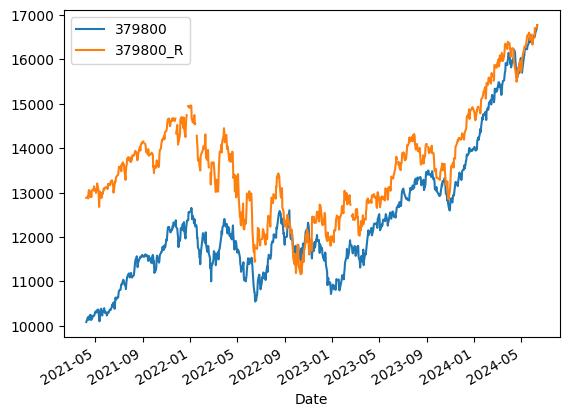

In [52]:
df_379800.to_frame().join(df_379800r).plot()

In [53]:
etfs = ['069500', '273130', '148070']
df = df_etfs[etfs].join(df_379800r).loc[start_date:]
df

,069500,273130,148070,379800_R
Date,,,,
2017-06-29,27193,99855.0,106044.0,7549.014665
2017-06-30,27109,99810.0,105817.0,7560.589054
2017-07-03,27170,99745.0,105613.0,7578.060320
2017-07-04,27002,99655.0,105190.0,NaN
2017-07-05,27105,99620.0,105253.0,7589.073356
...,...,...,...,...
2024-06-04,36390,110605.0,111850.0,16507.998052
2024-06-05,36755,110820.0,112200.0,16703.579031
2024-06-07,37240,111075.0,112610.0,16681.616938


In [54]:
ticker = '379800_R'
etf_names.update({ticker:'KODEX 미국S&P500TR assumed from S&P500 rate of return'})
etfs.append(ticker)

## Backtest

In [55]:
bts = Backtest(df, metrics=metrics, initial_capital=10000000,
               equity_names=etf_names, commissions=None)

backtest period reset: 2017-06-29 ~ 2024-06-11
rate of nan filled forward::
  069500: 0.000
  273130: 0.000
  148070: 0.000
  379800_R: 0.033


In [56]:
name = 'KOSPI'
ticker = '069500'
bts.buy_n_hold(ticker, name=name)

In [57]:
{x:etf_names[x] for x in etfs}

{'069500': 'KODEX 200',
 '273130': 'KODEX 종합채권(AA-이상)액티브',
 '148070': 'KOSEF 국고채10년',
 '379800_R': 'KODEX 미국S&P500TR assumed from S&P500 rate of return'}

In [58]:
name = 'ETF COMB1'
weights = [0.2, 0.2, 0.3, 0.3]
weights = dict(zip(etfs, weights))
bts.build(weights, name, period='Y')

In [59]:
name = 'ETF COMB1 (M)'
weights = [0.2, 0.2, 0.3, 0.3]
weights = dict(zip(etfs, weights))
bts.build(weights, name, period='M', capital_flow=1000000)

In [60]:
name = 'ETF COMB2'
weights = [0.3, 0.2, 0.3, 0.2]
weights = dict(zip(etfs, weights))
bts.build(weights, name, period='Y')

,KOSPI,ETF COMB1,ETF COMB1 (M),ETF COMB2
start,2017-06-28 00:00:00,2017-06-28 00:00:00,2017-06-28 00:00:00,2017-06-28 00:00:00
end,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00
total_return,0.359183,0.450954,0.430813,0.383078
cagr,0.045118,0.054983,0.052865,0.04774
max_drawdown,-0.380162,-0.189178,-0.190569,-0.20192
avg_drawdown,-0.047992,-0.012449,-0.012622,-0.015412
avg_drawdown_days,94.576923,26.809524,27.47561,39.288136
daily_vol,0.184222,0.078006,0.078233,0.077309
daily_sharpe,0.337775,0.743129,0.714828,0.657651
daily_sortino,0.555855,1.165093,1.118762,1.04768


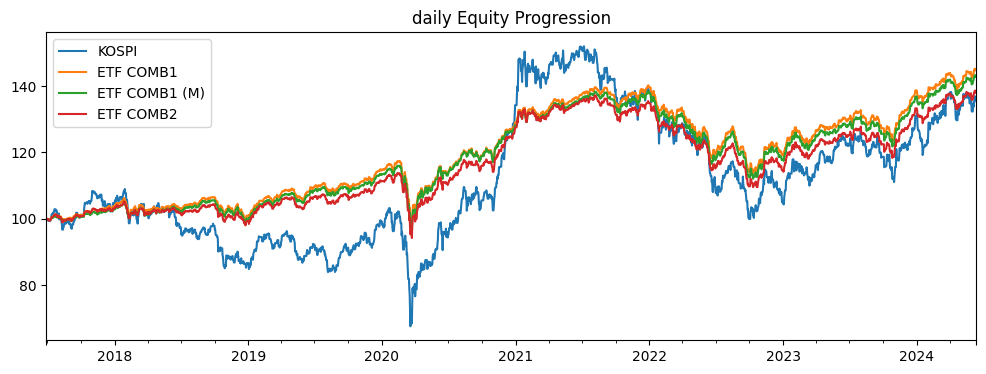

In [61]:
bts.run(figsize=(12,4))

In [82]:
bts.show_weights('ETF COMB1')

KODEX 200                                              0.2
KODEX 종합채권(AA-이상)액티브                                   0.2
KOSEF 국고채10년                                           0.3
KODEX 미국S&P500TR assumed from S&P500 rate of return    0.3
dtype: float64

In [83]:
bts.show_weights('ETF COMB2')

KODEX 200                                              0.3
KODEX 종합채권(AA-이상)액티브                                   0.2
KOSEF 국고채10년                                           0.3
KODEX 미국S&P500TR assumed from S&P500 rate of return    0.2
dtype: float64

# Stats
- check plot_histogram in bt api
- check bayesian_returns2 in backtestlib

,KOSPI,TDF COMB
start,2021-04-08 00:00:00,2021-04-08 00:00:00
end,2024-06-11 00:00:00,2024-06-11 00:00:00
total_return,-0.07205,0.095495
cagr,-0.02327,0.029135
max_drawdown,-0.342102,-0.174055
avg_drawdown,-0.085707,-0.016229
avg_drawdown_days,229.0,56.210526
daily_vol,0.136883,0.052665
daily_sharpe,-0.050308,0.402564
daily_sortino,-0.079776,0.611235


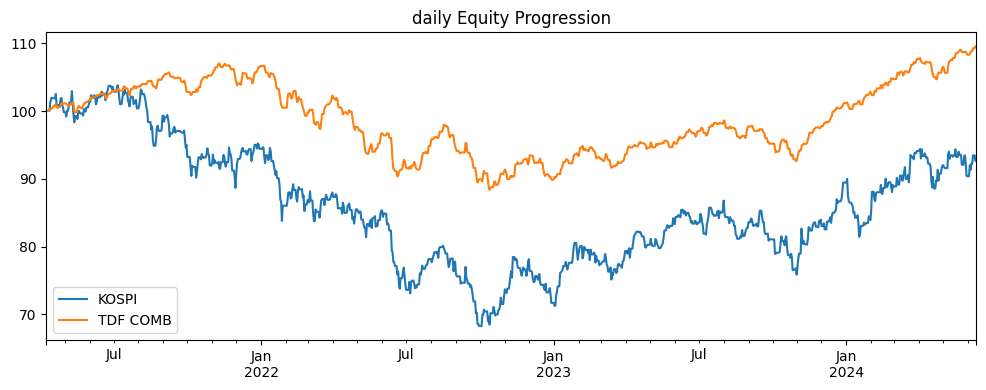

In [21]:
bts.run(figsize=(12,4))

In [71]:
a = bts.portfolios['TDF COMB']
a.data

,K55301BU6139,K55206C95800
2021-04-08,NaN,NaN
2021-04-09,1394.652287,1266.682110
2021-04-10,1394.652287,1266.682110
2021-04-11,1394.652287,1266.682110
2021-04-12,1396.754325,1269.287008
...,...,...
2024-06-07,1568.220582,1343.426434
2024-06-08,1568.220582,1343.426434
2024-06-09,1568.220582,1343.426434
2024-06-10,1567.620000,1350.640000


In [72]:
a.weights

,TDF COMB,TDF COMB>K55301BU6139,TDF COMB>K55206C95800
2021-04-08,1.0,0.000000,0.000000
2021-04-09,1.0,0.499983,0.499959
2021-04-10,1.0,0.499983,0.499959
2021-04-11,1.0,0.499983,0.499959
2021-04-12,1.0,0.499846,0.500097
...,...,...,...
2024-06-07,1.0,0.509505,0.490461
2024-06-08,1.0,0.509505,0.490461
2024-06-09,1.0,0.509505,0.490461
2024-06-10,1.0,0.508071,0.491895


In [73]:
a = a.data.join(a.weights).apply(lambda x: x[0]*x[3] + x[1]*x[4], axis=1).to_frame('TDF COMB').dropna()
a

,TDF COMB
2021-04-09,1330.591882
2021-04-10,1330.591882
2021-04-11,1330.591882
2021-04-12,1332.927874
2021-04-13,1334.244003
...,...
2024-06-07,1457.915651
2024-06-08,1457.915651
2024-06-09,1457.915651
2024-06-10,1460.836582


(-0.2, 0.2)

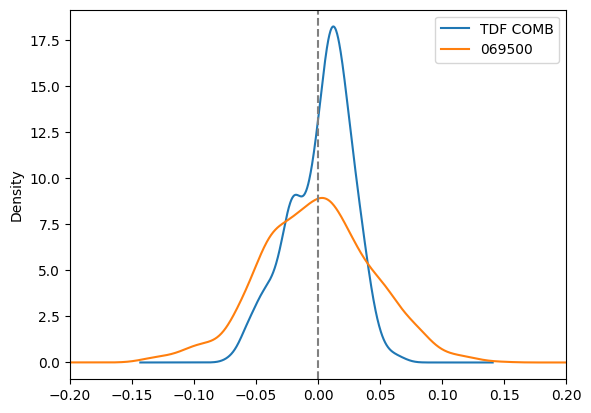

In [81]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
_ = a.pct_change(30).plot(kind='kde', ax=ax)
_ = b.pct_change(30).plot(kind='kde', ax=ax)
ax.axvline(x=0, c='grey', ls='--')
ax.set_xlim([-0.2,0.2])

In [43]:
a.data

,K55301BU6139,K55206C95800
2021-04-08,NaN,NaN
2021-04-09,1394.652287,1266.682110
2021-04-10,1394.652287,1266.682110
2021-04-11,1394.652287,1266.682110
2021-04-12,1396.754325,1269.287008
...,...,...
2024-06-07,1568.220582,1343.426434
2024-06-08,1568.220582,1343.426434
2024-06-09,1568.220582,1343.426434
2024-06-10,1567.620000,1350.640000


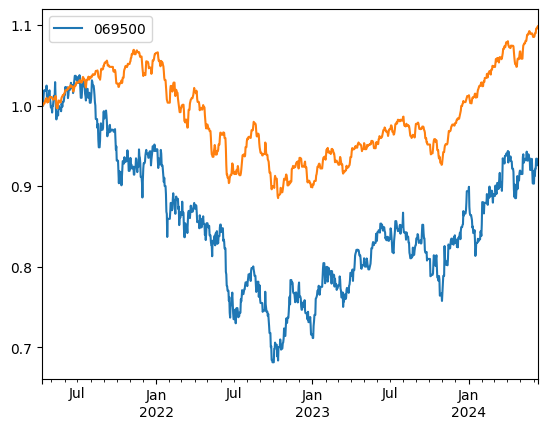

In [47]:
b = bts.portfolios['KOSPI'].data.dropna()
ax = b.mul(1/b.iloc[0]).plot()
_ = a.mul(1/a.iloc[0]).plot(ax=ax)

,KOSPI,TDF COMB
start,2021-04-08 00:00:00,2021-04-08 00:00:00
end,2024-06-11 00:00:00,2024-06-11 00:00:00
total_return,-0.07205,0.095495
cagr,-0.02327,0.029135
max_drawdown,-0.342102,-0.174055
avg_drawdown,-0.085707,-0.016229
avg_drawdown_days,229.0,56.210526
daily_vol,0.136883,0.052665
daily_sharpe,-0.050308,0.402564
daily_sortino,-0.079776,0.611235


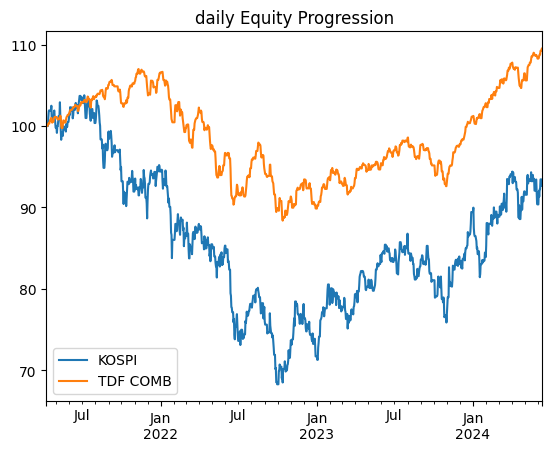

In [27]:
bts.run()

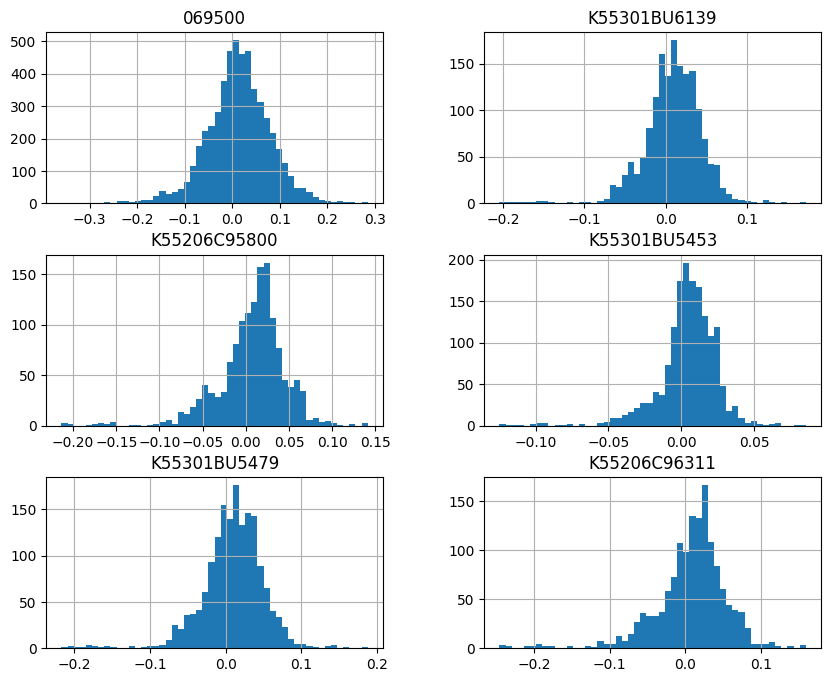

In [44]:
_ = df_etfs[['069500']].join(df_tdfs).ffill().pct_change(30).hist(bins=50, figsize=(10,8))

# testing: bayesian

In [1]:
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

print(f"Running on PyMC v{pm.__version__}")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC v5.15.1


In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(seed=42)

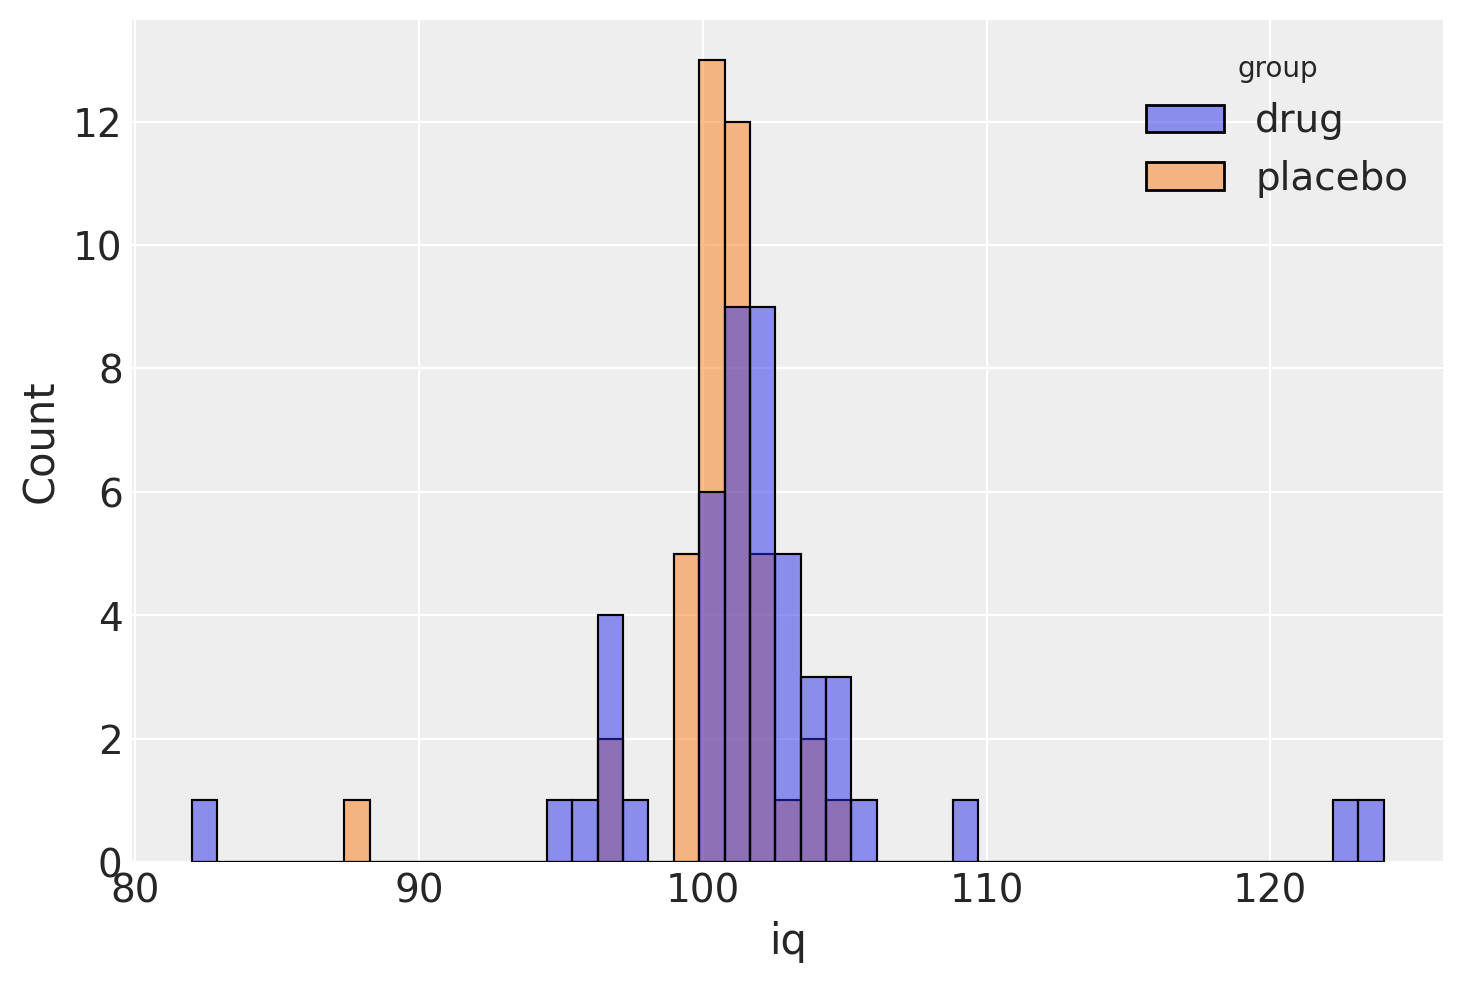

In [3]:
# fmt: off
iq_drug = np.array([
    101, 100, 102, 104, 102, 97, 105, 105, 98, 101, 100, 123, 105, 103, 
    100, 95, 102, 106, 109, 102, 82, 102, 100, 102, 102, 101, 102, 102,
    103, 103, 97, 97, 103, 101, 97, 104, 96, 103, 124, 101, 101, 100,
    101, 101, 104, 100, 101
])

iq_placebo = np.array([
    99, 101, 100, 101, 102, 100, 97, 101, 104, 101, 102, 102, 100, 105,
    88, 101, 100, 104, 100, 100, 100, 101, 102, 103, 97, 101, 101, 100,
    101, 99, 101, 100, 100, 101, 100, 99, 101, 100, 102, 99, 100, 99
])
# fmt: on

df1 = pd.DataFrame({"iq": iq_drug, "group": "drug"})
df2 = pd.DataFrame({"iq": iq_placebo, "group": "placebo"})
indv = pd.concat([df1, df2]).reset_index()

sns.histplot(data=indv, x="iq", hue="group");

In [63]:
mu_m = indv.iq.mean()
#mu_s = indv.iq.std() * 2
mu_s = indv.iq.std()

sigma_low = 10**-1
sigma_high = 10

with pm.Model() as model:
    group1_mean = pm.Normal("group1_mean", mu=mu_m, sigma=mu_s)
    group2_mean = pm.Normal("group2_mean", mu=mu_m, sigma=mu_s)

    group1_std = pm.Uniform("group1_std", lower=sigma_low, upper=sigma_high)
    group2_std = pm.Uniform("group2_std", lower=sigma_low, upper=sigma_high)

    lambda_1 = group1_std**-2
    lambda_2 = group2_std**-2

    nu_minus_one = pm.Exponential("nu_minus_one", 1 / 29.0)
    nu = pm.Deterministic("nu", nu_minus_one + 1)
    nu_log10 = pm.Deterministic("nu_log10", np.log10(nu))

    group1 = pm.StudentT("drug", nu=nu, mu=group1_mean, lam=lambda_1, observed=iq_drug)
    group2 = pm.StudentT("placebo", nu=nu, mu=group2_mean, lam=lambda_2, observed=iq_placebo)

    diff_of_means = pm.Deterministic("difference of means", group1_mean - group2_mean)
    diff_of_stds = pm.Deterministic("difference of stds", group1_std - group2_std)
    effect_size = pm.Deterministic(
        "effect size", diff_of_means / np.sqrt((group1_std**2 + group2_std**2) / 2)
    )

In [64]:
with model:
    idata = pm.sample()

Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:02

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


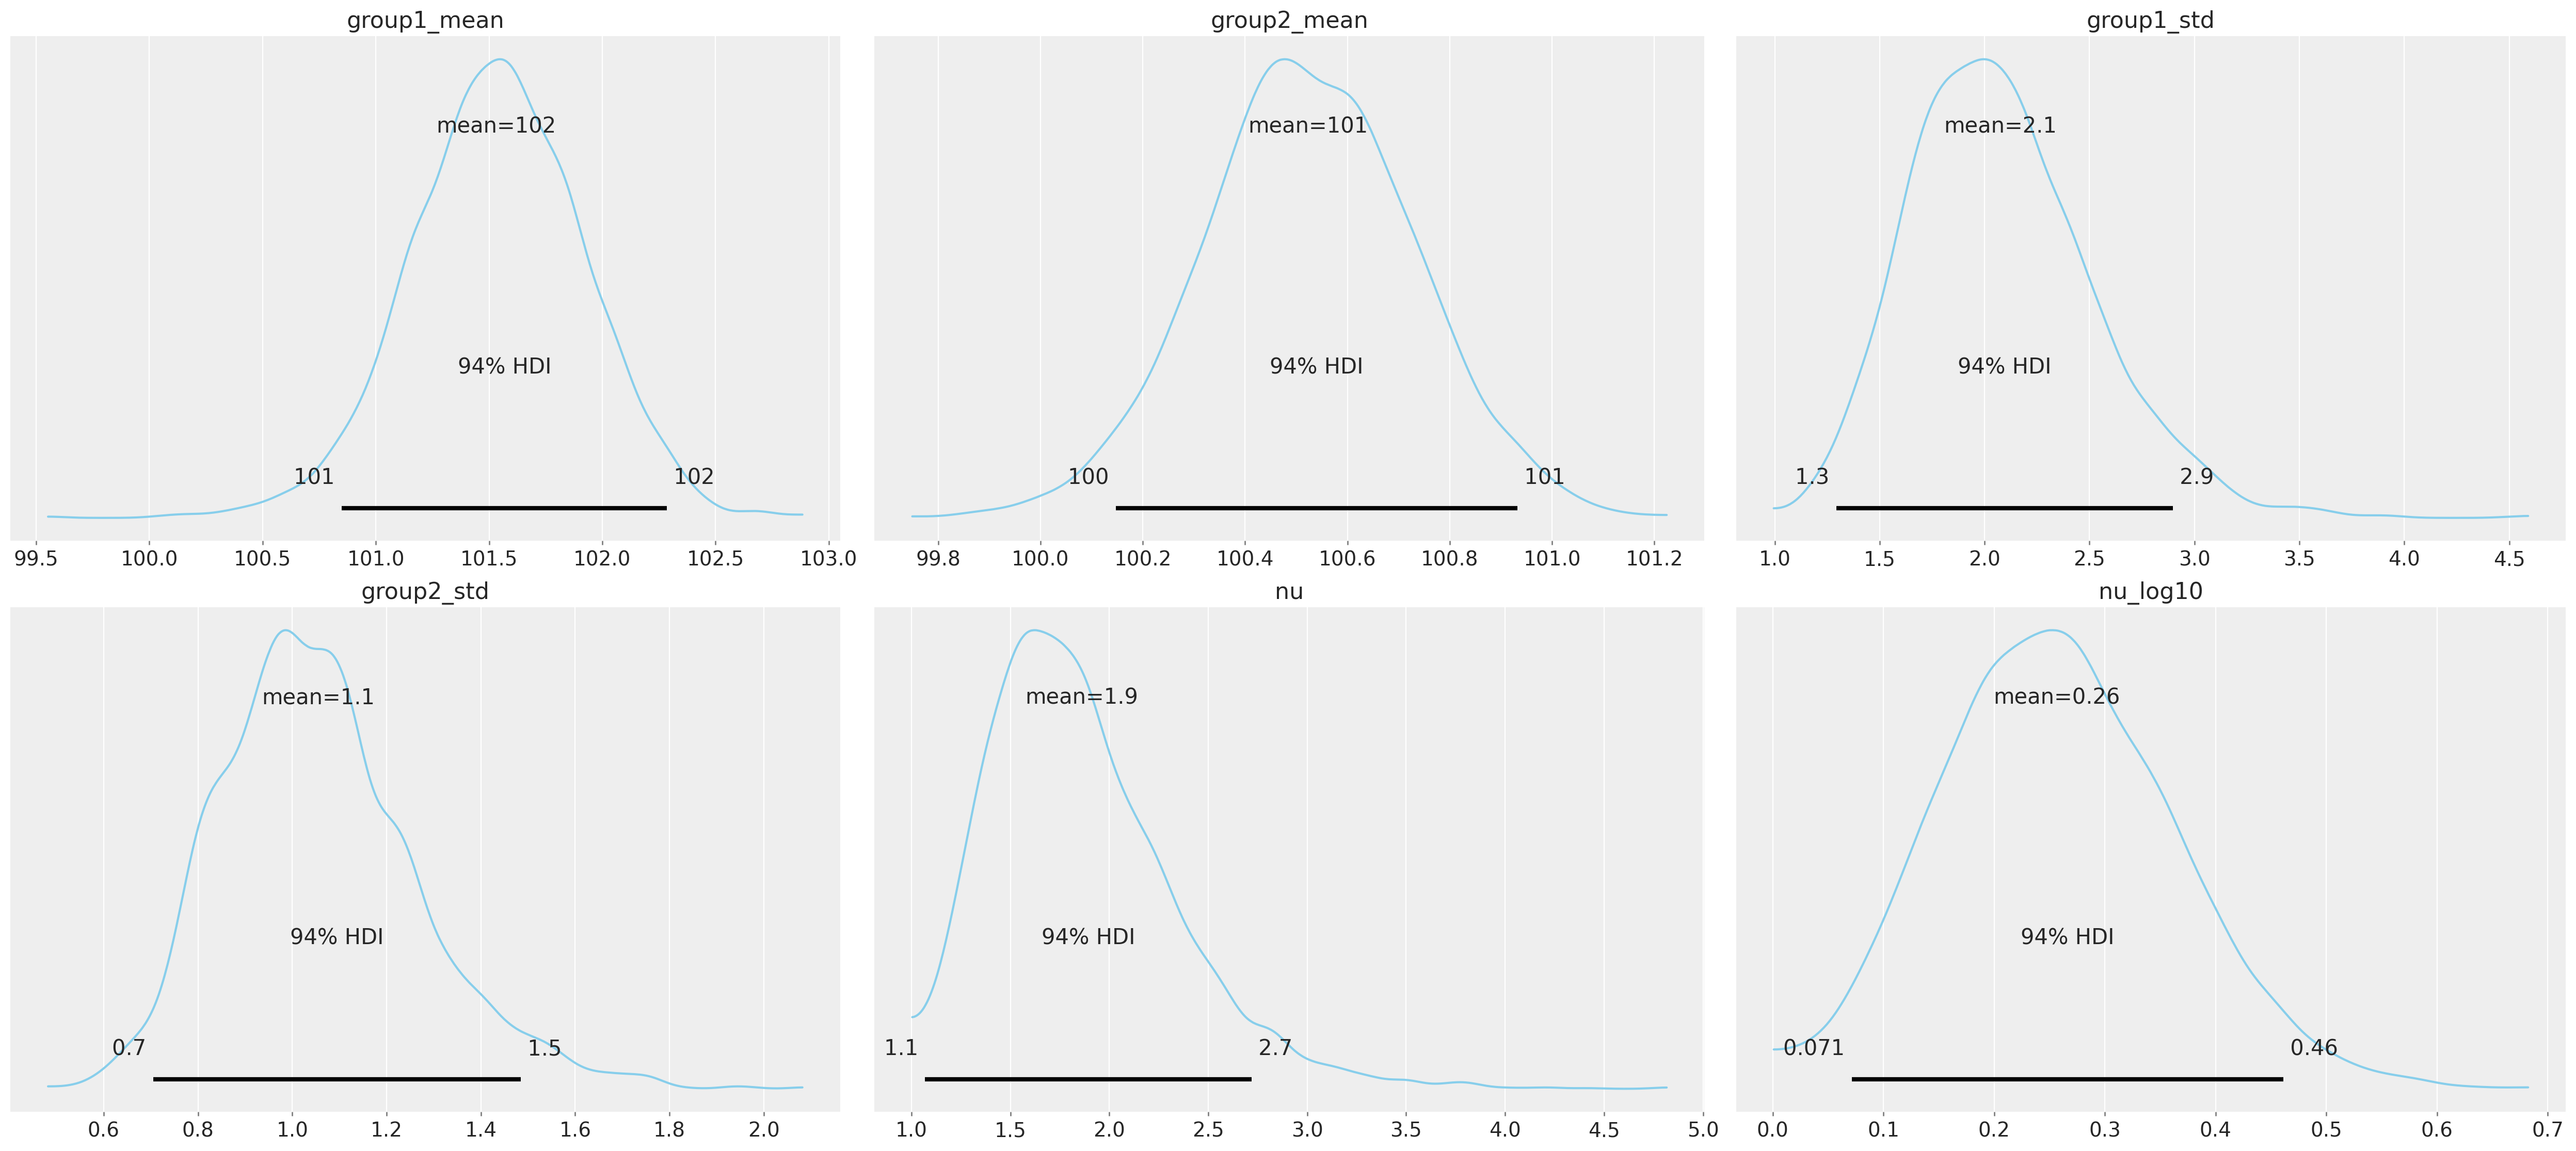

In [12]:
_ = az.plot_posterior(
    idata,
    var_names=["group1_mean", "group2_mean", "group1_std", "group2_std", "nu", "nu_log10"],
    color="#87ceeb",
)

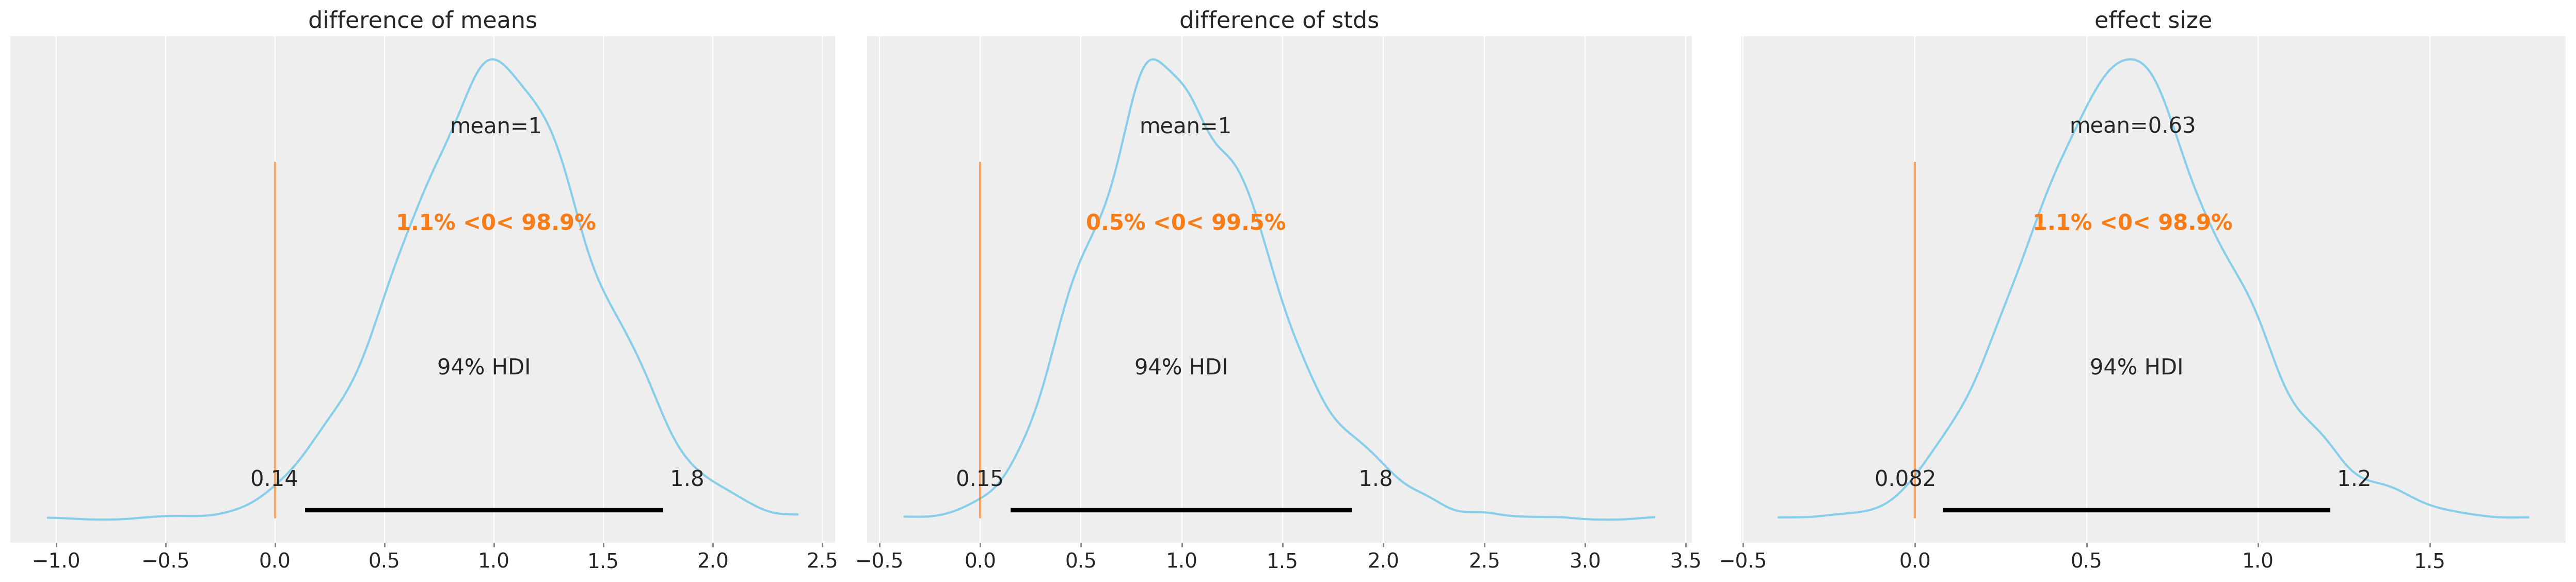

In [13]:
_ = az.plot_posterior(
    idata,
    var_names=["difference of means", "difference of stds", "effect size"],
    ref_val=0,
    color="#87ceeb",
);

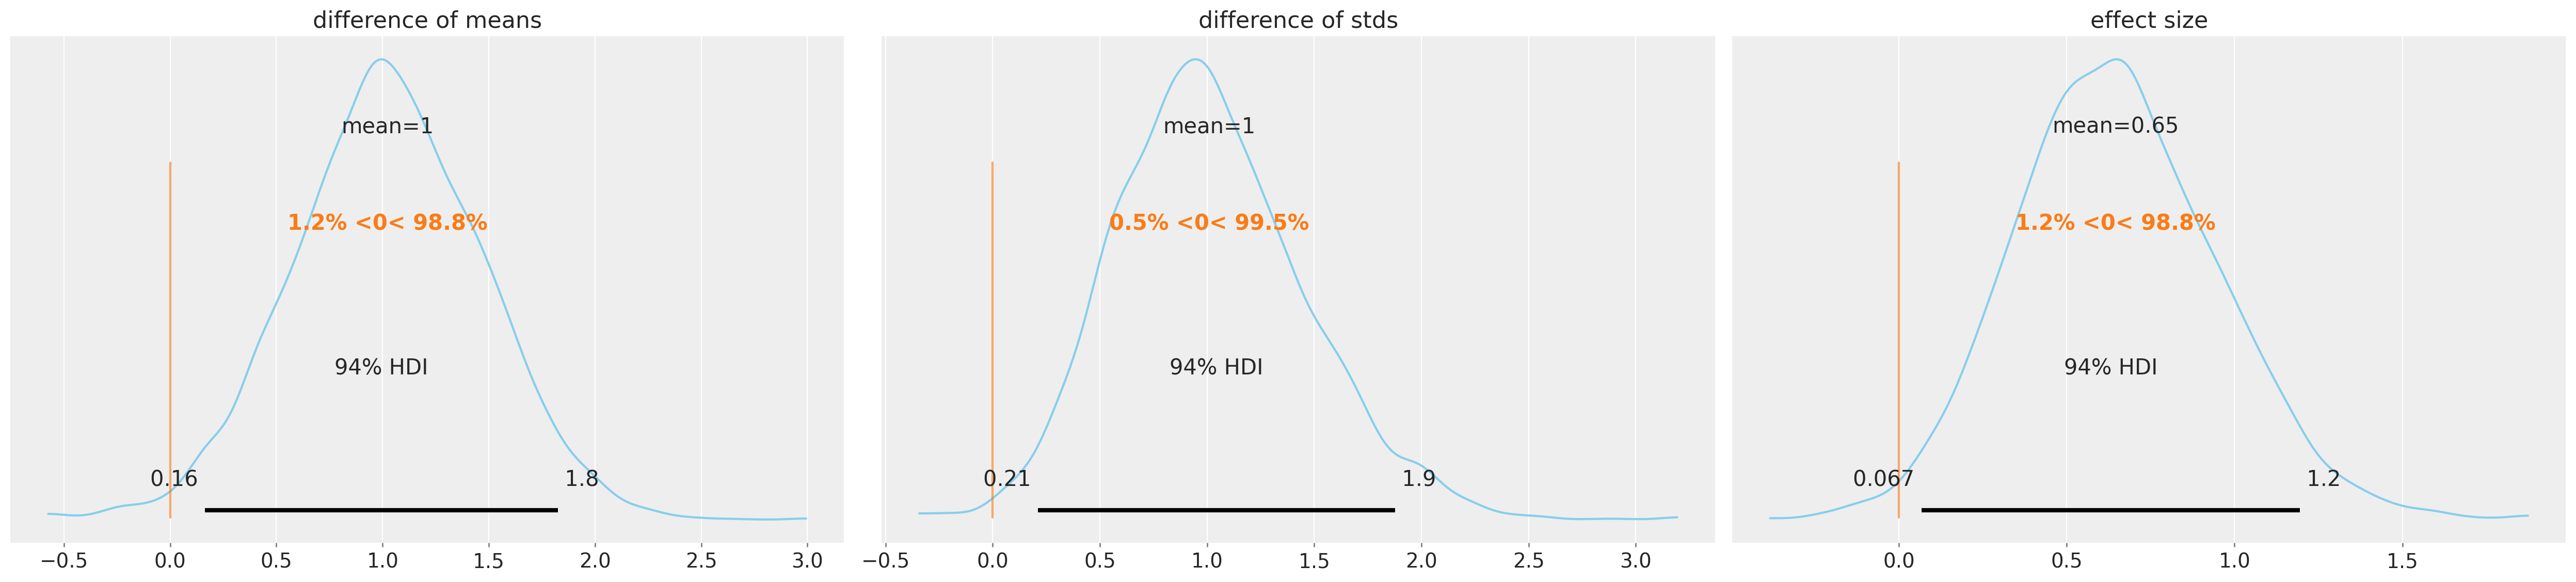

In [65]:
_ = az.plot_posterior(
    idata,
    var_names=["difference of means", "difference of stds", "effect size"],
    ref_val=0,
    color="#87ceeb",
);

In [14]:
az.summary(idata, var_names=["difference of means", "difference of stds", "effect size"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
difference of means,1.009,0.439,0.137,1.773,0.007,0.005,3612.0,2850.0,1.0
difference of stds,1.019,0.455,0.152,1.844,0.007,0.006,3776.0,2955.0,1.0
effect size,0.634,0.301,0.082,1.210,0.005,0.004,3463.0,2784.0,1.0


In [66]:
az.summary(idata, var_names=["difference of means", "difference of stds", "effect size"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
difference of means,1.025,0.447,0.164,1.826,0.008,0.006,3474.0,2863.0,1.0
difference of stds,1.010,0.445,0.210,1.877,0.007,0.006,3790.0,2623.0,1.0
effect size,0.646,0.305,0.067,1.194,0.005,0.004,3545.0,2798.0,1.0


## Implement

In [100]:
#bts.run_results['KOSPI'].data # AttributeError: 'PerformanceStats' object has no attribute 'data'
df = bts.portfolios['KOSPI'].data
df = df.join(bts.portfolios['TDF COMB'].data)
df.head()

,069500,K55301BU6139,K55206C95800
2021-04-08,NaN,NaN,NaN
2021-04-09,39862.0,1394.652287,1266.682110
2021-04-10,39862.0,1394.652287,1266.682110
2021-04-11,39862.0,1394.652287,1266.682110
2021-04-12,39862.0,1396.754325,1269.287008


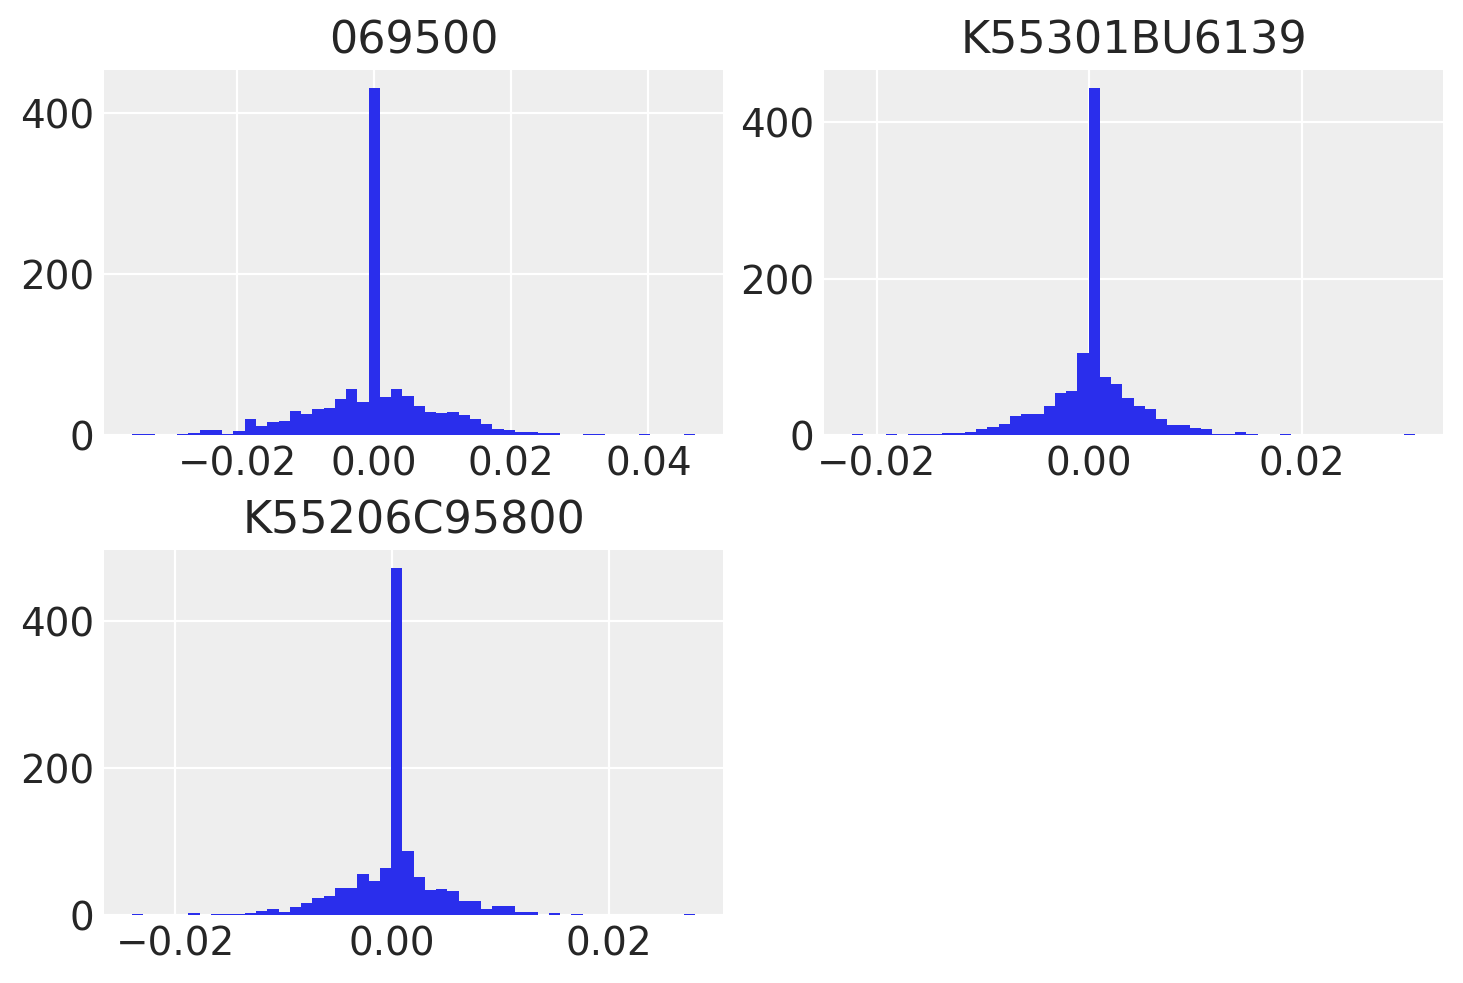

In [101]:
#period = round(365/4)
period = 1
df_ret = df.pct_change(period).dropna()
_ = df_ret.hist(bins=50)

In [102]:
df_ret.mean()

069500         -0.000027
K55301BU6139    0.000111
K55206C95800    0.000065
dtype: float64

In [62]:
mu_m = indv.iq.mean()
mu_s = indv.iq.std() * 2

sigma_low = 10**-1
sigma_high = 10

with pm.Model() as model:
    group1_mean = pm.Normal("group1_mean", mu=mu_m, sigma=mu_s)
    group2_mean = pm.Normal("group2_mean", mu=mu_m, sigma=mu_s)

    group1_std = pm.Uniform("group1_std", lower=sigma_low, upper=sigma_high)
    group2_std = pm.Uniform("group2_std", lower=sigma_low, upper=sigma_high)

    lambda_1 = group1_std**-2
    lambda_2 = group2_std**-2

    nu_minus_one = pm.Exponential("nu_minus_one", 1 / 29.0)
    nu = pm.Deterministic("nu", nu_minus_one + 1)
    nu_log10 = pm.Deterministic("nu_log10", np.log10(nu))

    group1 = pm.StudentT("drug", nu=nu, mu=group1_mean, lam=lambda_1, observed=iq_drug)
    group2 = pm.StudentT("placebo", nu=nu, mu=group2_mean, lam=lambda_2, observed=iq_placebo)

    diff_of_means = pm.Deterministic("difference of means", group1_mean - group2_mean)
    diff_of_stds = pm.Deterministic("difference of stds", group1_std - group2_std)
    effect_size = pm.Deterministic(
        "effect size", diff_of_means / np.sqrt((group1_std**2 + group2_std**2) / 2)
    )

Index(['069500', 'K55301BU6139', 'K55206C95800'], dtype='object')

In [84]:
mean_prior['K55301BU6139']

0.003076658522122705

In [106]:
import pytensor.tensor as at

mean_prior, std_prior = df_ret.mean(), df_ret.std()

m = 10
std_low, std_high = std_prior / m, std_prior * m

YEAR = 365
T = YEAR ** .5
mean, std, returns = {}, {}, {}
assets = df_ret.columns
num_assets = len(assets) # flag to plot comparisson if comparing two hists

with pm.Model() as model:
    #nu = pm.Exponential('nu_minus_two', 1 / 29, testval=4) + 2.
    nu = pm.Exponential('nu_minus_two', 1 / 29) + 1.
    for i, col in enumerate(assets):
        df = df_ret[col]
        mean[i] = pm.Normal(f'mean_{col}', mu=mean_prior[col], sigma=std_prior[col])
        std[i] = pm.Uniform(f'std_{col}', lower=std_low[col], upper=std_high[col])
        returns[i] = pm.StudentT(f'returns_{col}', nu=nu, mu=mean[i], sigma=std[i], observed=df)
        pm.Deterministic(f'vol_{col}', at.std(returns[i]) * T)
        pm.Deterministic(f'sharpe_{col}', (at.mean(returns[i]) / at.std(returns[i])) * T)
    if num_assets == 2:
        mean_diff = pm.Deterministic('mean diff', mean[0] - mean[1])
        pm.Deterministic('std diff', std[0] - std[1])
        pm.Deterministic('effect size', mean_diff / (std[0] ** 2 + std[1] ** 2) ** .5 / 2)

In [107]:
with model:
    # HMC NUTS Sampling
    #cores, _ = print_machine_type()
    trace = pm.sample(#draws=draws, tune=tune,
                      #chains=chains, cores=cores,
                      #target_accept=target_accept,
                      #return_inferencedata=False, # TODO: what's for?
                      progressbar=True)

Sampling 4 chains, 3 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:06

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


In [109]:
az.summary(trace, var_names=["sharpe_069500", "sharpe_K55206C95800", "sharpe_K55301BU6139"])

/home/lbk/.cache/pypoetry/virtualenvs/pf-APoYtgC9-py3.12/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sharpe_069500,-0.060,0.0,-0.060,-0.060,0.0,0.0,4000.0,4000.0,NaN
sharpe_K55206C95800,0.268,0.0,0.268,0.268,0.0,0.0,4000.0,4000.0,NaN
sharpe_K55301BU6139,0.502,0.0,0.502,0.502,0.0,0.0,4000.0,4000.0,NaN


In [105]:
az.summary(trace)

/home/lbk/.cache/pypoetry/virtualenvs/pf-APoYtgC9-py3.12/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/lbk/.cache/pypoetry/virtualenvs/pf-APoYtgC9-py3.12/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mean_069500,0.000,0.000,-0.000,0.000,0.0,0.0,4970.0,3157.0,1.0
mean_K55206C95800,0.000,0.000,-0.000,0.000,0.0,0.0,4935.0,2959.0,1.0
mean_K55301BU6139,0.000,0.000,-0.000,0.000,0.0,0.0,4833.0,3036.0,1.0
nu_minus_two,0.011,0.011,0.000,0.030,0.0,0.0,2995.0,1674.0,1.0
sharpe_069500,-0.060,0.000,-0.060,-0.060,0.0,0.0,4000.0,4000.0,NaN
sharpe_K55206C95800,0.268,0.000,0.268,0.268,0.0,0.0,4000.0,4000.0,NaN
sharpe_K55301BU6139,0.502,0.000,0.502,0.502,0.0,0.0,4000.0,4000.0,NaN
std_069500,0.004,0.000,0.004,0.005,0.0,0.0,4332.0,3270.0,1.0
std_K55206C95800,0.002,0.000,0.002,0.002,0.0,0.0,4964.0,2453.0,1.0
std_K55301BU6139,0.002,0.000,0.002,0.002,0.0,0.0,5275.0,3464.0,1.0


In [88]:
df_ret.mean()

069500         -0.001255
K55301BU6139    0.003077
K55206C95800    0.001630
dtype: float64

## function

In [110]:
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import pytensor.tensor as at

print(f"Running on PyMC v{pm.__version__}")

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(seed=42)

# see: https://www.pymc.io/projects/examples/en/latest/case_studies/BEST.html

def estimate_bayesian(df_ret, periods=1, multiplier_std=10, days_in_year=365,
                      sample_draws=1000, sample_tune=1000, target_accept=0.8):
    mean_prior = df_ret.mean()
    std_prior = df_ret.std()
    std_low = std_prior / multiplier_std
    std_high = std_prior * multiplier_std
    
    T = (days_in_year/periods) ** .5
    #T = (days_in_year/12/periods) ** .5
    mean, std, returns = {}, {}, {}
    
    assets = df_ret.columns
    num_assets = len(assets) # flag to plot comparisson if comparing two hists
    
    with pm.Model() as model:
        #nu = pm.Exponential('nu_minus_two', 1 / 29, testval=4) + 2.
        nu = pm.Exponential('nu_minus_two', 1 / 29) + 1.
        
        for i, col in enumerate(assets):
            df = df_ret[col]
            mean[i] = pm.Normal(f'mean_{col}', mu=mean_prior[col], sigma=std_prior[col])
            std[i] = pm.Uniform(f'std_{col}', lower=std_low[col], upper=std_high[col])
            returns[i] = pm.StudentT(f'returns_{col}', nu=nu, mu=mean[i], sigma=std[i], observed=df)
            #pm.Deterministic(f'test_{col}', std[i]*T)
            #pm.Deterministic(f'test_{col}', returns[i].mean())
            pm.Deterministic(f'vol_{col}', returns[i].distribution.mean)
            #pm.Deterministic(f'vol_{col}', at.std(returns[i]) * T)
            #pm.Deterministic(f'sharpe_{col}', (at.mean(returns[i]) / at.std(returns[i])) * T)
            #pm.Deterministic(f'vol_{col}', std[i]*T)
            #pm.Deterministic(f'sharpe_{col}', (mean[i] / std[i]) * T)
        
        
        if num_assets == 2:
            mean_diff = pm.Deterministic('mean diff', mean[0] - mean[1])
            pm.Deterministic('std diff', std[0] - std[1])
            pm.Deterministic('effect size', mean_diff / (std[0] ** 2 + std[1] ** 2) ** .5 / 2)

        trace = pm.sample(draws=sample_draws, tune=sample_tune,
                          #chains=chains, cores=cores,
                          target_accept=target_accept,
                          #return_inferencedata=False, # TODO: what's for?
                          progressbar=True)

    #return az.summary(trace)
    return trace

Running on PyMC v5.15.1


In [125]:
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import pytensor.tensor as pt

print(f"Running on PyMC v{pm.__version__}")

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(seed=42)

# see: https://www.pymc.io/projects/examples/en/latest/case_studies/BEST.html

def estimate_bayesian(df_ret, periods=1, multiplier_std=10, days_in_year=365,
                      sample_draws=1000, sample_tune=1000, target_accept=0.8):
    mean_prior = df_ret.mean()
    std_prior = df_ret.std()
    std_low = std_prior / multiplier_std
    std_high = std_prior * multiplier_std
    
    T = (days_in_year/periods) ** .5
    #T = (days_in_year/12/periods) ** .5
    mean, std, returns = {}, {}, {}
    
    assets = df_ret.columns
    num_assets = len(assets) # flag to plot comparisson if comparing two hists
    
    with pm.Model() as model:
        nu = pm.Exponential('nu_minus_two', 1 / 29, testval=4) + 2.
        
        for i, col in enumerate(assets):
            df = df_ret[col]
            mean[i] = pm.Normal(f'mean_{col}', mu=mean_prior[col], sigma=std_prior[col])
            std[i] = pm.Uniform(f'std_{col}', lower=std_low[col], upper=std_high[col])
            returns[i] = pm.StudentT(f'returns_{col}', nu=nu, mu=mean[i], sigma=std[i], observed=df)
            std2 = std[i] * pt.sqrt(nu / (nu - 2))
            pm.Deterministic(f'vol_{col}',  std2*T)
            pm.Deterministic(f'sharpe_{col}', (mean[i] / std2) * T)

        
        
        
        if num_assets == 2:
            mean_diff = pm.Deterministic('mean diff', mean[0] - mean[1])
            pm.Deterministic('std diff', std[0] - std[1])
            pm.Deterministic('effect size', mean_diff / (std[0] ** 2 + std[1] ** 2) ** .5 / 2)

        trace = pm.sample(draws=sample_draws, tune=sample_tune,
                          #chains=chains, cores=cores,
                          target_accept=target_accept,
                          #return_inferencedata=False, # TODO: what's for?
                          progressbar=True)

    #return az.summary(trace)
    return trace

Running on PyMC v5.15.1


In [126]:
#bts.run_results['KOSPI'].data # AttributeError: 'PerformanceStats' object has no attribute 'data'
df = bts.portfolios['KOSPI'].data
df = df.join(bts.portfolios['TDF COMB'].data)
df.head()

,069500,K55301BU6139,K55206C95800
2021-04-08,NaN,NaN,NaN
2021-04-09,39862.0,1394.652287,1266.682110
2021-04-10,39862.0,1394.652287,1266.682110
2021-04-11,39862.0,1394.652287,1266.682110
2021-04-12,39862.0,1396.754325,1269.287008


In [127]:
import numpy as np

#period = round(365/4)
periods = 1
df_ret = df.pct_change(periods).dropna()
#df_ret = np.log(df / df.shift(1)).dropna()
#_ = df_ret.hist(bins=50)

In [128]:
#estimate_bayesian(df_ret.iloc[:, 0].to_frame(), periods)
trace = estimate_bayesian(df_ret.iloc[:, :2], periods)

Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:05

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


In [129]:
var_names=["sharpe_069500", "sharpe_K55301BU6139", "vol_069500", "vol_K55301BU6139"]
az.summary(trace, var_names=var_names)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sharpe_069500,0.019,0.069,-0.108,0.163,0.001,0.001,3390.0,2973.0,1.0
sharpe_K55301BU6139,0.092,0.083,-0.034,0.257,0.001,0.001,3145.0,2579.0,1.0
vol_069500,1.479,1.957,0.339,3.560,0.042,0.029,2787.0,1963.0,1.0
vol_K55301BU6139,0.630,0.799,0.150,1.526,0.017,0.012,2737.0,1951.0,1.0


In [109]:
_ = az.plot_posterior(
    trace,
    #var_names=["sharpe_069500", "sharpe_K55301BU6139"],
    #var_names=["std_069500", "std_K55301BU6139"],
    #var_names=["mean diff", "std diff", "effect size"],
    #var_names=["std_069500", "test_069500"],
    var_names = var_names,
    ref_val=0,
    color="#87ceeb",
);

/home/lbk/.cache/pypoetry/virtualenvs/pf-APoYtgC9-py3.12/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/lbk/.cache/pypoetry/virtualenvs/pf-APoYtgC9-py3.12/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  func(*args, **kwargs)
/home/lbk/.cache/pypoetry/virtualenvs/pf-APoYtgC9-py3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


ValueError: Image size of 5489x301946 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 3312x552 with 4 Axes>

In [ ]:
        summary = arviz.summary(traces[burnin:])['mean'].to_dict()
        ax = arviz.plot_trace(traces[burnin:],
                          figsize=(fig_width, len(traces.varnames)*height_unit),
                          lines=summary)
        for i, mn in enumerate(summary.values()):
            ax[i, 0].annotate(f'{mn:.2f}', 
                              xy=(mn, 0), 
                              xycoords='data', 
                              xytext=(5, 10), 
                              textcoords='offset points', 
                              rotation=90, 
                              va='bottom', 
                              fontsize='large', 
                              color='#AA0022')

## Implement 2

In [83]:
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import pytensor.tensor as pt

print(f"Running on PyMC v{pm.__version__}")

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(seed=42)

# see: https://www.pymc.io/projects/examples/en/latest/case_studies/BEST.html

def estimate_bayesian(df_price, periods=1, multiplier_std=10, days_in_year=365,
                      sample_draws=1000, sample_tune=1000, target_accept=0.9):
    
    df_ret = df_price.pct_change(periods).dropna()
    
    mean_prior = df_ret.mean()
    std_prior = df_ret.std()
    std_low = std_prior / multiplier_std
    std_high = std_prior * multiplier_std

    T = (days_in_year/periods/12) ** .5 # montly
    
    mean, std, returns = {}, {}, {}
    
    assets = df_ret.columns
    num_assets = len(assets) # flag to plot comparisson if comparing two hists
    
    with pm.Model() as model:
        nu = pm.Exponential('nu_minus_two', 1 / 29, testval=4) + 2.
        
        for i, col in enumerate(assets):
            df = df_ret[col]
            mean[i] = pm.Normal(f'mean_{col}', mu=mean_prior[col], sigma=std_prior[col])
            std[i] = pm.Uniform(f'std_{col}', lower=std_low[col], upper=std_high[col])
            returns[i] = pm.StudentT(f'returns_{col}', nu=nu, mu=mean[i], sigma=std[i], observed=df)
            
            #std2 = std[i] * pt.sqrt(nu / (nu - 2))
            std2 = std[i]
            pm.Deterministic(f'vol_{col}',  std2*T)
            pm.Deterministic(f'sharpe_{col}', (mean[i] / std2) * T)

        if num_assets == 2:
            mean_diff = pm.Deterministic('mean diff', mean[0] - mean[1])
            pm.Deterministic('std diff', std[0] - std[1])
            pm.Deterministic('effect size', mean_diff / (std[0] ** 2 + std[1] ** 2) ** .5 / 2)

        trace = pm.sample(draws=sample_draws, tune=sample_tune,
                          #chains=chains, cores=cores,
                          target_accept=target_accept,
                          #return_inferencedata=False, # TODO: what's for?
                          progressbar=True)

    #return az.summary(trace)
    return trace

Running on PyMC v5.15.1


In [40]:
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import pytensor.tensor as pt

#print(f"Running on PyMC v{pm.__version__}")

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(seed=42)

# see: https://www.pymc.io/projects/examples/en/latest/case_studies/BEST.html

def estimate_bayesian(df_price, multiplier_std=10, days_in_year=365,
                      sample_draws=1000, sample_tune=1000, target_accept=0.9):
    
    periods=1 
    df_ret = df_price.pct_change(periods).dropna()
    
    mean_prior = df_ret.mean()
    std_prior = df_ret.std()
    std_low = std_prior / multiplier_std
    std_high = std_prior * multiplier_std

    assets = list(df_ret.columns)
    num_assets = len(assets) # flag to plot comparisson if comparing two hists
    coords={'asset': assets}
    
        
    with pm.Model(coords=coords) as model:
        nu = pm.Exponential('nu_minus_two', 1 / 29, testval=4) + 2.
        
        mean = pm.Normal(f'mean', mu=mean_prior, sigma=std_prior, dims='asset')
        std = pm.Uniform(f'std', lower=std_low, upper=std_high, dims='asset')
        #returns = pm.StudentT(f'daily_return', nu=nu, mu=mean, sigma=std, observed=df_ret)
        
        #std = std * pt.sqrt(nu / (nu - 2))
        T = (days_in_year/periods/12) ** .5 # montly
        pm.Deterministic(f'montly_vol',  std2*T)
        pm.Deterministic(f'montly_sharpe', (mean / std2) * T)

        if num_assets == 2:
            mean_diff = pm.Deterministic('mean diff', mean[0] - mean[1])
            pm.Deterministic('std diff', std[0] - std[1])
            pm.Deterministic('effect size', mean_diff / (std[0] ** 2 + std[1] ** 2) ** .5 / 2)

        trace = pm.sample(draws=sample_draws, tune=sample_tune,
                          #chains=chains, cores=cores,
                          target_accept=target_accept,
                          #return_inferencedata=False, # TODO: what's for?
                          progressbar=True)

    #return az.summary(trace)
    return trace

In [15]:
df_etfs

,273130,453850,284430,069500,379800,411060,305080,304660,148070,261220
Date,,,,,,,,,,
2002-10-14,NaN,NaN,NaN,5184,NaN,NaN,NaN,NaN,NaN,NaN
2002-10-15,NaN,NaN,NaN,5312,NaN,NaN,NaN,NaN,NaN,NaN
2002-10-16,NaN,NaN,NaN,5335,NaN,NaN,NaN,NaN,NaN,NaN
2002-10-17,NaN,NaN,NaN,5410,NaN,NaN,NaN,NaN,NaN,NaN
2002-10-18,NaN,NaN,NaN,5642,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2024-06-04,110605.0,8325.0,12895.0,36390,16500.0,14835.0,11930.0,7850.0,111850.0,14245.0
2024-06-05,110820.0,8410.0,12950.0,36755,16530.0,14710.0,11950.0,7945.0,112200.0,14215.0
2024-06-07,111075.0,8475.0,13010.0,37240,16625.0,14895.0,11925.0,8005.0,112610.0,14660.0


In [16]:
df_tdfs

,K55301BU6139,K55206C95800,K55301BU5453,K55301BU5479,K55206C96311
date,,,,,
2017-08-14,NaN,NaN,NaN,1001.091988,NaN
2017-08-15,NaN,NaN,NaN,1001.091988,NaN
2017-08-16,NaN,NaN,NaN,1007.198649,NaN
2017-08-17,NaN,NaN,NaN,1011.603454,NaN
2017-08-18,NaN,NaN,NaN,1008.29985,NaN
...,...,...,...,...,...
2024-06-13,1580.132132,1352.042638,1270.094504,1700.855288,1404.300971
2024-06-14,1583.93582,NaN,1272.402672,1705.360202,1414.503884
2024-06-15,1583.93582,NaN,1272.402672,1705.360202,NaN


In [17]:
df = pd.DataFrame(None, index=pd.date_range(start='2018-07-26', end='2024-06-11'))
df = df.join(df_etfs['069500']).join(df_tdfs['K55301BU5479']).join(df_tdfs['K55206C95800']).ffill()

In [18]:
#df = df_etfs[['069500']].join(df_tdfs['K55301BU5479']).join(df_tdfs['K55206C95800'])
get_date_range(df)

,start date,end date
069500,2018-07-26,2024-06-11
K55301BU5479,2018-07-26,2024-06-11
K55206C95800,2018-07-26,2024-06-11


In [19]:
#df = df.loc['2018-07-26':]

In [20]:
df.index.max() - df.index.min()

Timedelta('2147 days 00:00:00')

In [21]:
df.isna().sum()

069500          0
K55301BU5479    0
K55206C95800    0
dtype: int64

In [22]:
#len(df) * 365/251

In [23]:
bts = Backtest(df, metrics=metrics, initial_capital=10000000,
               equity_names=equity_names, commissions=None)

backtest period reset: 2018-07-26 ~ 2024-06-11
rate of nan filled forward::
  069500: 0.000
  K55301BU5479: 0.000
  K55206C95800: 0.000


In [24]:
for t in df.columns:
    bts.buy_n_hold(t, name=t)

In [25]:
bts.run(plot=False)

,069500,K55301BU5479,K55206C95800
start,2018-07-25 00:00:00,2018-07-25 00:00:00,2018-07-25 00:00:00
end,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00
total_return,0.406752,0.541466,0.346793
cagr,0.059749,0.076358,0.051929
max_drawdown,-0.345974,-0.229146,-0.219971
avg_drawdown,-0.052904,-0.015822,-0.017244
avg_drawdown_days,82.2,27.514286,34.636364
daily_vol,0.158248,0.086599,0.074234
daily_sharpe,0.332012,0.629739,0.507719
daily_sortino,0.524828,0.921998,0.75463


In [26]:
# check cagr
t = len(df) /365
pi = df['069500'][0]
pf = df['069500'][-1]
(pf/pi)**(1/t) - 1

0.05978616703430828

In [38]:
#trace = estimate_bayesian(df, periods=1, days_in_year=251)
#trace = estimate_bayesian(df, periods=1, days_in_year=365)
trace = estimate_bayesian(df)

Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:09

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


In [39]:
#az.summary(trace, var_names=['sharpe_069500', 'sharpe_K55206C95800', 'sharpe_K55301BU5479'])
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mean[069500],0.000,0.000,0.000,0.000,0.000,0.000,6635.0,2875.0,1.0
mean[K55301BU5479],0.000,0.000,0.000,0.000,0.000,0.000,6312.0,3238.0,1.0
mean[K55206C95800],0.000,0.000,0.000,0.000,0.000,0.000,7052.0,2645.0,1.0
montly_sharpe[0],0.282,0.147,-0.004,0.550,0.002,0.001,6705.0,2919.0,1.0
montly_sharpe[1],0.613,0.141,0.354,0.876,0.002,0.001,6220.0,3250.0,1.0
montly_sharpe[2],0.608,0.147,0.332,0.881,0.002,0.001,7269.0,2350.0,1.0
montly_vol[0],0.025,0.001,0.023,0.026,0.000,0.000,6768.0,3094.0,1.0
montly_vol[1],0.012,0.000,0.011,0.013,0.000,0.000,7267.0,2888.0,1.0
montly_vol[2],0.010,0.000,0.010,0.011,0.000,0.000,6624.0,2416.0,1.0
nu_minus_two,0.004,0.004,0.000,0.012,0.000,0.000,4906.0,2401.0,1.0


In [85]:
trace = estimate_bayesian(df, periods=31, days_in_year=365)
az.summary(trace, var_names=['sharpe_069500', 'sharpe_K55206C95800', 'sharpe_K55301BU5479'])

Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:09

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sharpe_069500,0.151,0.026,0.103,0.199,0.0,0.0,7355.0,3085.0,1.0
sharpe_K55206C95800,0.354,0.028,0.302,0.406,0.0,0.0,5905.0,2682.0,1.0
sharpe_K55301BU5479,0.404,0.028,0.350,0.455,0.0,0.0,4973.0,2822.0,1.0


In [55]:
trace = estimate_bayesian(df, periods=21, days_in_year=251)
az.summary(trace, var_names=['sharpe_069500', 'sharpe_K55206C95800', 'sharpe_K55301BU5479'])

Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:08

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sharpe_069500,0.106,0.022,0.063,0.148,0.0,0.0,6693.0,2982.0,1.0
sharpe_K55206C95800,0.263,0.023,0.219,0.306,0.0,0.0,6813.0,3111.0,1.0
sharpe_K55301BU5479,0.292,0.025,0.244,0.336,0.0,0.0,6299.0,3072.0,1.0


In [58]:
trace = estimate_bayesian(df, periods=21, days_in_year=251,
                         sample_draws=5000, sample_tune=5000, target_accept=0.95)
az.summary(trace, var_names=['sharpe_069500', 'sharpe_K55206C95800', 'sharpe_K55301BU5479'])

Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:45

Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 46 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sharpe_069500,0.106,0.022,0.065,0.148,0.0,0.0,25127.0,16154.0,1.0
sharpe_K55206C95800,0.263,0.024,0.220,0.309,0.0,0.0,23116.0,14665.0,1.0
sharpe_K55301BU5479,0.292,0.024,0.248,0.339,0.0,0.0,28102.0,14942.0,1.0
